# MeerKAT S-band Galactic Plane Survey Grid Generator

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic
from astropy.coordinates import Angle, Latitude, Longitude
import astropy.units as u
from scipy.interpolate import interp1d
from IPython.display import display, Markdown, Latex, HTML
from psrqpy import QueryATNF

## Survey Region Definitions

### L-band Galactic plane

In [2]:
lband_gp = {
    "latitude": [-5.2, 5.2], # deg
    "longitude": [-100, -10], # deg
    "dwell": 637, # sec
    "duration": 800 * 60 * 60, # sec
    "frequency": 1284e6, # Hz
    "bandwidth": 856e6 # Hz
}

### S-band Galactic plane

In [3]:
sband_gp = {
    "latitude": [-1.4, 1.4],
    "longitude": [-100, 15],
    "dwell": 1274,
    "duration": 2000 * 60 * 60,
    "frequency": 2406.25e6,
    "bandwidth": 875e6
}

### S-band Galactic centre

In [4]:
sband_gc = {
    "latitude": [0, 0],
    "longitude": [0, 0],
    "dwell": 1274,
    "duration": 200 * 60 * 60,
    "frequency": 3062.5e6,
    "bandwidth": 875e6
}

## Telescope Parameters

In [5]:
c = 299792458.0
dish_diameter = 13.5  # m
fwhm_filename = "FWHM.npy"
data = np.load(fwhm_filename, allow_pickle=True, encoding='latin1').tolist()
fwhm_mean = np.vstack((data['FWHM_Gx_horz'], data['FWHM_Gy_horz'], 
                       data['FWHM_Gx_vert'], data['FWHM_Gy_vert']
                      )).mean(axis=0)
fwhm_gx = np.vstack((data['FWHM_Gx_horz'], data['FWHM_Gx_vert'])).mean(axis=0)
fwhm_gy = np.vstack((data['FWHM_Gy_horz'], data['FWHM_Gy_vert'])).mean(axis=0)
fwhm_freq = data['freqMHz'] * 1e6
# There are various artefacts in the FWHM measurement so we will fit a degree 2 polymial
fwhm_fit = np.polyfit(fwhm_freq, fwhm_mean, deg=2)
fwhm_x_fit = np.polyfit(fwhm_freq, fwhm_gx, deg=2)
fwhm_y_fit = np.polyfit(fwhm_freq, fwhm_gy, deg=2)
fwhm = lambda freq: np.polyval(fwhm_fit, freq)
fwhm_x = lambda freq: np.polyval(fwhm_x_fit, freq)
fwhm_y = lambda freq: np.polyval(fwhm_y_fit, freq)

## Griding Parameters

In [6]:
def gridding_lengths(frequency, fwhm_factor):
    hs = fwhm(frequency) / fwhm_factor
    vs = np.sqrt(3) * hs / 2
    ho = hs / 2
    return hs, vs, ho

## Grid Generator

In [7]:
def generate_grid(survey_description, reference_frequency=None, fwhm_factor=np.sqrt(5)):
    sd = survey_description
    if reference_frequency:
        freq = reference_frequency
    else:
        freq = sd["frequency"]
    hs, vs, ho = gridding_lengths(freq, fwhm_factor)
    start_x, start_y = (sd["longitude"][0] + ho, sd["latitude"][0]+ho)
    end_x, end_y = (sd["longitude"][1] - ho, sd["latitude"][1] - ho)
    pointing_centres = []
    x, y = start_x, start_y
    nrows = int(round((end_y - start_y) / vs + 0.5))
    ncols = int(round((end_x - start_x) / hs + 0.5))
    for col in range(ncols):
        for row in range(nrows):
            x = start_x + hs * col + ho * (row % 2 == 0)
            y = start_y + vs * row
            pointing_centres.append((x, y))
    response = {}
    response["pointings"] = np.array(pointing_centres)
    response["survey_parameters"] = sd
    response["reference_frequency"] = freq
    response["beam_radius"] = ho
    response["npointings"] = response["pointings"].shape[0]
    response["survey_duration"] = sd["dwell"] * response["npointings"]
    response["oversubscription"] = response["survey_duration"] / sd["duration"]
    response["fwhm_factor"] = fwhm_factor
    return response

def plot_grid(grid):
    ax = plt.gca()
    freq = grid["survey_parameters"]["frequency"]
    fhwm_factor = grid["fwhm_factor"]
    plt.scatter(*grid["pointings"].T)
    for x, y in grid["pointings"]:
        ax.add_artist(plt.Circle((x, y), grid["beam_radius"], fill=None))
    plt.xlabel("$l^{\circ}$")
    plt.ylabel("$b^{\circ}$")

(-1.0, 1.0)

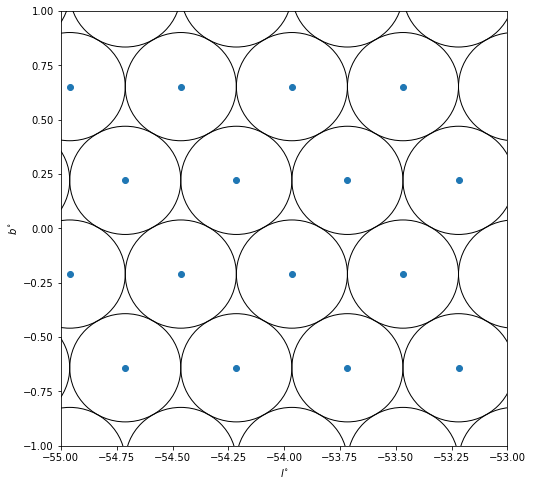

In [8]:
grid = generate_grid(lband_gp, fwhm_factor=np.sqrt(5))
plt.figure(figsize=[8,8])
plot_grid(grid)
plt.xlim(-55,-53)
plt.ylim(-1, 1)

In [9]:
def describe_grid(grid):
    sd = grid["survey_parameters"]
    display(Markdown('# Grid description'))
    display(Markdown('**Parameters:**'))
    display(Markdown('* **Npointings:** {}'.format(grid["npointings"])))
    display(Markdown('* **Dwell per pointing:** {} seconds'.format(sd["dwell"])))
    display(Markdown('* **Expected duration:** {} hours'.format(sd["duration"] / (60 * 60))))
    display(Markdown('* **Actual duration:** {} hours'.format(grid["npointings"] * sd["dwell"] / (60 * 60))))
    display(Markdown('* **Fraction of expected:** {:.2f}'.format(grid["oversubscription"])))
    display(Markdown('* **Beam overlap:** FWHM / $\sqrt%.1f$'%(grid["fwhm_factor"]**2)))
    display(Markdown('* **Beam radius:** %.4f$^{\circ}$' % (grid["beam_radius"])))
    display(Markdown('* **Reference frequency:** {:.1f} MHz'.format(grid["reference_frequency"] / 1e6)))    
describe_grid(grid)

# Grid description

**Parameters:**

* **Npointings:** 4140

* **Dwell per pointing:** 637 seconds

* **Expected duration:** 800.0 hours

* **Actual duration:** 732.55 hours

* **Fraction of expected:** 0.92

* **Beam overlap:** FWHM / $\sqrt5.0$

* **Beam radius:** 0.2488$^{\circ}$

* **Reference frequency:** 1284.0 MHz

**Beamshape (bottom, top, middle):**

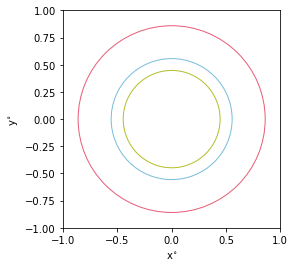

In [10]:
def show_beamshape(frequencies):
    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
    for freq in frequencies:
        x = fwhm_x(freq)
        y = fwhm_y(freq)
        e = Ellipse(xy=(0, 0), width=x, height=y, fill=None)
        ax.add_artist(e)
        e.set_edgecolor(np.random.rand(3))
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    plt.xlabel("x$^{\circ}$")
    plt.ylabel("y$^{\circ}$")
display(Markdown('**Beamshape (bottom, top, middle):**'))
show_beamshape((856e6, 1284e6, 1712e6))

In [11]:
def grid_to_table(grid):
    data = []
    catalogue = []
    for ii, pointing in enumerate(grid["pointings"]):
        l, b = pointing[0], pointing[1]
        c = SkyCoord(frame=Galactic, l=l, b=b, unit=(u.deg, u.deg))
        eq = c.transform_to(ICRS)
        catalogue.append((l, b))
        ra, dec = eq.to_string('hmsdms', sep=':').split()
        data.append(('MSGPS_L_{:04d}'.format(ii), l, b, ra, dec))

    display(HTML(
       '<table><tr>{}</tr></table>'.format(
           '</tr><tr>'.join(
               '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
           )
    ))
    l, b = np.array(catalogue).T    
    catalogue = SkyCoord(frame=Galactic, l=l, b=b, unit=(u.deg, u.deg))
    return catalogue
    
display(Markdown('**Pointing table:**'))
catalogue = grid_to_table(grid)

**Pointing table:**

MSGPS_L_0000,-99.50232797360937,-4.951163986804686,08:15:33.9182,-43:55:42.8369
MSGPS_L_0001,-99.75116398680468,-4.520167369197522,08:16:47.4771,-43:29:00.2688
MSGPS_L_0002,-99.50232797360937,-4.089170751590358,08:19:31.5224,-43:26:54.2567
MSGPS_L_0003,-99.75116398680468,-3.658174133983194,08:20:42.7063,-43:00:01.5315
MSGPS_L_0004,-99.50232797360937,-3.22717751637603,08:23:25.3515,-42:57:35.4169
MSGPS_L_0005,-99.75116398680468,-2.7961808987688657,08:24:34.2351,-42:30:33.1607
MSGPS_L_0006,-99.50232797360937,-2.3651842811617017,08:27:15.4661,-42:27:47.3029
MSGPS_L_0007,-99.75116398680468,-1.9341876635545376,08:28:22.1244,-42:00:36.1197
MSGPS_L_0008,-99.50232797360937,-1.5031910459473736,08:31:01.9298,-41:57:30.8761
MSGPS_L_0009,-99.75116398680468,-1.0721944283402096,08:32:06.4378,-41:30:11.3484
MSGPS_L_0010,-99.50232797360937,-0.6411978107330452,08:34:44.8091,-41:26:47.0739


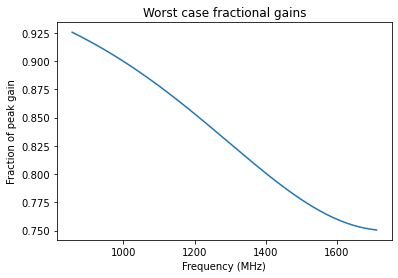

In [12]:
gauss = lambda x,mu,sigma: np.exp(-0.5 * ((x-mu)/sigma)**2)
# FWHM = 2.355 sigma
def worst_case_gains(grid):
    max_offset = 2*grid["beam_radius"]/np.sqrt(3)
    plt.plot(fwhm_freq/1e6, gauss(max_offset, 0, fwhm(fwhm_freq)/2.355))
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Fraction of peak gain")
    plt.title("Worst case fractional gains")
    
worst_case_gains(grid) 
    

## Known Pulsars

In [3]:
query = QueryATNF()

In [14]:
ras, decs, rows = [], [], []
p = query.table["JNAME","RAJ", "DECJ", "S1400"]
for row in p:
    name,ra,dec,_ = row 
    eq = SkyCoord(frame=ICRS, ra=ra, dec=dec, unit=(u.hour, u.deg))
    c = eq.transform_to(Galactic)
    if c.l.deg < 350.0 and c.l.deg > 260.0 and abs(c.b.deg) < 5.5:
        ras.append(ra)
        decs.append(dec)
        rows.append(row)
pulsars = SkyCoord(frame=ICRS, ra=ras, dec=decs, unit=(u.hour, u.deg))
print("{} known pulsars in survey region".format(len(pulsars)))

626 known pulsars in survey region


In [15]:
c = catalogue.transform_to(ICRS)
idx, d2d, d3d = pulsars.match_to_catalog_sky(c)
pointings_with_pulsars = {}
for pidx, (cidx, dist) in enumerate(zip(idx, d2d)):
    pointing_id = "MSGPS_L_{:04d}".format(cidx)
    if (pointing_id, cidx) in pointings_with_pulsars:
        pointings_with_pulsars[(pointing_id, cidx)].append((rows[pidx], dist))
    else:
        pointings_with_pulsars[(pointing_id, cidx)] = [(rows[pidx], dist)]

for key, value in sorted(pointings_with_pulsars.items(), key=lambda kv: -1*len(kv[1])):
    name, cidx = key
    print("{} ({}) has {} pulsars".format(
            name, 
            c[cidx].to_string('hmsdms', sep=":"),
            len(value)))
    for pulsar, dist in value:
        fgain = gauss(dist.deg, 0, fwhm(1284e6)/2.355)
        if hasattr(pulsar["S1400"], "mask"):
            s1400 = "--"
        else:
            s1400 = "{:0.2f} mJy".format(fgain*pulsar["S1400"])
        print("    - {}, separation {:0.3f}, fractional gain {:.3f}, expected S1400 {}".format(
                pulsar["JNAME"].ljust(10), dist, fgain, s1400))

MSGPS_L_2035 (13:01:15.5198 -63:03:38.6704) has 4 pulsars
    - J1301-6305, separation 0.065 deg, fractional gain 0.990, expected S1400 0.49 mJy
    - J1301-6310, separation 0.120 deg, fractional gain 0.968, expected S1400 0.11 mJy
    - J1302-6313, separation 0.203 deg, fractional gain 0.912, expected S1400 0.16 mJy
    - J1303-6305, separation 0.199 deg, fractional gain 0.916, expected S1400 0.33 mJy
MSGPS_L_3415 (16:23:27.8939 -49:53:07.4752) has 4 pulsars
    - J1622-4944, separation 0.198 deg, fractional gain 0.916, expected S1400 0.48 mJy
    - J1622-4950, separation 0.121 deg, fractional gain 0.967, expected S1400 4.64 mJy
    - J1623-4949, separation 0.099 deg, fractional gain 0.978, expected S1400 0.35 mJy
    - J1623-5005, separation 0.212 deg, fractional gain 0.904, expected S1400 --
MSGPS_L_3624 (16:38:04.7431 -46:02:03.922) has 4 pulsars
    - J1637-4553, separation 0.145 deg, fractional gain 0.954, expected S1400 1.43 mJy
    - J1637-46  , separation 0.200 deg, fractional

    - J0919-42  , separation 0.765 deg, fractional gain 0.269, expected S1400 --
MSGPS_L_0564 (09:23:25.3006 -49:55:14.7061) has 1 pulsars
    - J0922-4949, separation 0.214 deg, fractional gain 0.902, expected S1400 0.47 mJy
MSGPS_L_0629 (09:22:28.4608 -52:11:47.0892) has 1 pulsars
    - J0922-52  , separation 0.209 deg, fractional gain 0.906, expected S1400 0.15 mJy
MSGPS_L_0674 (09:23:58.8486 -53:01:37.9874) has 1 pulsars
    - J0924-5302, separation 0.031 deg, fractional gain 0.998, expected S1400 1.10 mJy
MSGPS_L_0721 (09:31:59.6073 -53:34:27.8722) has 1 pulsars
    - J0932-5327, separation 0.134 deg, fractional gain 0.960, expected S1400 0.14 mJy
MSGPS_L_0723 (09:35:53.2459 -52:56:19.9621) has 1 pulsars
    - J0934-5249, separation 0.243 deg, fractional gain 0.877, expected S1400 2.81 mJy
MSGPS_L_0790 (09:39:32.2587 -54:34:33.8281) has 1 pulsars
    - J0940-5428, separation 0.230 deg, fractional gain 0.888, expected S1400 0.59 mJy
MSGPS_L_0748 (09:42:07.7593 -52:37:22.3909) has 1

MSGPS_L_2886 (15:23:46.6434 -57:11:24.1533) has 1 pulsars
    - J1524-5706, separation 0.112 deg, fractional gain 0.972, expected S1400 0.44 mJy
MSGPS_L_2861 (15:24:12.7293 -58:11:01.2187) has 1 pulsars
    - J1524-5819, separation 0.139 deg, fractional gain 0.957, expected S1400 0.09 mJy
MSGPS_L_2960 (15:25:38.9352 -54:25:54.4658) has 1 pulsars
    - J1525-5417, separation 0.145 deg, fractional gain 0.954, expected S1400 0.17 mJy
MSGPS_L_2935 (15:26:06.1828 -55:25:29.6798) has 1 pulsars
    - J1525-5523, separation 0.079 deg, fractional gain 0.986, expected S1400 0.21 mJy
MSGPS_L_2957 (15:29:16.0591 -55:38:31.8294) has 1 pulsars
    - J1528-5547, separation 0.171 deg, fractional gain 0.937, expected S1400 0.07 mJy
MSGPS_L_2860 (15:27:36.5369 -58:24:13.7046) has 1 pulsars
    - J1528-5838, separation 0.252 deg, fractional gain 0.867, expected S1400 --
MSGPS_L_3006 (15:31:15.7256 -53:52:16.4658) has 1 pulsars
    - J1529-5355, separation 0.200 deg, fractional gain 0.915, expected S1400 

    - J1624-4721, separation 0.123 deg, fractional gain 0.967, expected S1400 0.15 mJy
MSGPS_L_3630 (16:27:20.2126 -44:16:23.3765) has 1 pulsars
    - J1626-44  , separation 0.111 deg, fractional gain 0.973, expected S1400 0.29 mJy
MSGPS_L_3582 (16:26:56.8645 -45:35:13.7887) has 1 pulsars
    - J1626-4537, separation 0.043 deg, fractional gain 0.996, expected S1400 1.19 mJy
MSGPS_L_3486 (16:26:05.3906 -48:12:57.3703) has 1 pulsars
    - J1626-4807, separation 0.133 deg, fractional gain 0.961, expected S1400 0.36 mJy
MSGPS_L_3534 (16:26:31.9129 -46:54:05.3087) has 1 pulsars
    - J1627-4706, separation 0.267 deg, fractional gain 0.853, expected S1400 0.15 mJy
MSGPS_L_3462 (16:26:54.6737 -48:41:40.591) has 1 pulsars
    - J1627-4845, separation 0.072 deg, fractional gain 0.988, expected S1400 0.47 mJy
MSGPS_L_3414 (16:26:27.6673 -50:00:33.377) has 1 pulsars
    - J1627-49  , separation 0.227 deg, fractional gain 0.891, expected S1400 0.12 mJy
MSGPS_L_3389 (16:28:11.4699 -50:57:56.7959) h

MSGPS_L_3942 (17:09:55.7897 -41:42:56.9965) has 1 pulsars
    - J1710-4148, separation 0.125 deg, fractional gain 0.966, expected S1400 0.30 mJy
MSGPS_L_4084 (17:11:54.5868 -38:17:19.9227) has 1 pulsars
    - J1711-3826, separation 0.152 deg, fractional gain 0.950, expected S1400 0.15 mJy
MSGPS_L_3870 (17:11:35.4491 -43:29:00.901) has 1 pulsars
    - J1711-4322, separation 0.127 deg, fractional gain 0.965, expected S1400 0.25 mJy
MSGPS_L_4060 (17:12:56.4945 -38:44:37.5864) has 1 pulsars
    - J1713-3844, separation 0.019 deg, fractional gain 0.999, expected S1400 0.26 mJy
MSGPS_L_4012 (17:13:31.7462 -40:03:20.0802) has 1 pulsars
    - J1713-3949, separation 0.239 deg, fractional gain 0.880, expected S1400 0.31 mJy
MSGPS_L_4083 (17:14:25.9921 -38:20:25.9147) has 1 pulsars
    - J1714-3810, separation 0.178 deg, fractional gain 0.931, expected S1400 --
MSGPS_L_4131 (17:13:50.5449 -37:01:44.6485) has 1 pulsars
    - J1715-3700, separation 0.265 deg, fractional gain 0.855, expected S1400 0

In [16]:
pointings_with_pulsars

{('MSGPS_L_0003',
  3): [(<Row index=344>
     JNAME         RAJ           DECJ      S1400 
                                            mJy  
     str12        str16         str16     float64
   ---------- ------------- ------------- -------
   J0821-4300 08:21:57.3653 -43:00:17.074      --,
   <Angle 0.22754027 deg>)],
 ('MSGPS_L_0097',
  97): [(<Row index=350>
     JNAME        RAJ         DECJ     S1400 
                                        mJy  
     str12       str16       str16    float64
   ---------- ----------- ----------- -------
   J0831-4406 08:31:32.43 -44:06:11.9    0.43,
   <Angle 0.11237043 deg>)],
 ('MSGPS_L_0032',
  32): [(<Row index=351>
     JNAME        RAJ          DECJ      S1400 
                                          mJy  
     str12       str16        str16     float64
   ---------- ------------ ------------ -------
   J0834-4159 08:34:17.807 -41:59:35.99    0.28,
   <Angle 0.14410316 deg>)],
 ('MSGPS_L_0166',
  166): [(<Row index=354>
     JNAME        

In [11]:
query.columns

Index(['PSRJ', 'PSRJ_REF', 'RAJ', 'RAJ_ERR', 'RAJ_REF', 'DECJ', 'DECJ_ERR',
       'DECJ_REF', 'POSEPOCH', 'POSEPOCH_REF',
       ...
       'MEDMASS', 'UPRMASS', 'MASSFN_ERR', 'MINOMDOT', 'H0_SD', 'ASSOC_ORIG',
       'ASSOC_REF', 'TYPE_ORIG', 'TYPE_REF', 'BINCOMP_ORIG'],
      dtype='object', length=367)